# Анализ факторов выживания персонажей из «Игры Престолов» с использованием логистической регрессии

В данном проекте планируется исследовать данные о персонажах из вселенной «Игры Престолов» с целью выявления факторов, влияющих на их шансы на выживание.

Гипотезы:

- шансы женщин на выживание выше;
- у замужних и женатых персонажей шансы выжить больше;
- чем больше персонаж убил людей, тем меньше его шанс выжить;
- титул дворянина увеличивает шансы выжить;
- чем популярнее персонаж, тем больше его шанс выжить.

Описание используемых признаков

1. **is_alive**: Индикатор выживания персонажа (1 - жив, 0 - мертв).
2. **male**: Индикатор пола персонажа (1 - мужчина, 0 - женщина).
3. **is_married**: Индикатор семейного положения персонажа (1 - замужем/женат, 0 - холост/незамужем).
4. **num_dead_relations**: Количество убитых персонажем своих родственников.
5. **is_noble**: Индикатор дворянского происхождения персонажа (1 - дворянин, 0 - недворянин).
6. **popularity**: Уровень популярности персонажа

План

1. Импорт библиотек
2. Предобработка и анализ данных
3. Построение логистической регрессии
4. Диагностика и надежность предсказания модели
5. Результаты

## Импорт библиотек

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Импорт библиотек
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
import statsmodels.stats.tests.test_influence
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Предобработка и анализ данных

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/character-predictions.csv')

In [ ]:
data.head()

,S.No,actual,pred,alive,plod,name,title,male,culture,dateOfBirth,...,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
0,1,0,0,0.054,0.946,Viserys II Targaryen,NaN,1,NaN,NaN,...,0.0,NaN,0,0,NaN,11,1,1,0.605351,0
1,2,1,0,0.387,0.613,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,...,NaN,1.0,1,1,97.0,1,1,1,0.896321,1
2,3,1,0,0.493,0.507,Addison Hill,Ser,1,NaN,NaN,...,NaN,NaN,0,1,NaN,0,0,0,0.267559,1
3,4,0,0,0.076,0.924,Aemma Arryn,Queen,0,NaN,82.0,...,NaN,0.0,1,1,23.0,0,0,0,0.183946,0
4,5,1,1,0.617,0.383,Sylva Santagar,Greenstone,0,Dornish,276.0,...,NaN,1.0,1,1,29.0,0,0,0,0.043478,1


Гипотезы определяют, какие переменные мы будем использовать в нашем анализе. Будет одна зависимая переменная — «is_alive» (жив или нет) и пять независимых: «male», «is_married», «num_dead_relations», «is_noble», «popularity». Каждая из этих переменных соответствует отдельной гипотезе, и мы сможем использовать их, чтобы предсказать шансы на выживание.

In [ ]:
# переименование столбцов
data.columns = [re.sub('(?<!^)(?=[A-Z])', '_', col).lower() for col in data.columns]

# проверка
data.columns

Index(['s._no', 'actual', 'pred', 'alive', 'plod', 'name', 'title', 'male',
       'culture', 'date_of_birth', 'dateo_fdeath', 'mother', 'father', 'heir',
       'house', 'spouse', 'book1', 'book2', 'book3', 'book4', 'book5',
       'is_alive_mother', 'is_alive_father', 'is_alive_heir',
       'is_alive_spouse', 'is_married', 'is_noble', 'age',
       'num_dead_relations', 'bool_dead_relations', 'is_popular', 'popularity',
       'is_alive'],
      dtype='object')

In [ ]:
got = data[['is_alive', 'male', 'is_married', 'num_dead_relations', 'is_noble', 'popularity']]
got.head()

,is_alive,male,is_married,num_dead_relations,is_noble,popularity
0,0,1,0,11,0,0.605351
1,1,1,1,1,1,0.896321
2,1,1,0,0,1,0.267559
3,0,0,1,0,1,0.183946
4,1,0,1,0,1,0.043478


In [ ]:
got.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   is_alive            1946 non-null   int64  
 1   male                1946 non-null   int64  
 2   is_married          1946 non-null   int64  
 3   num_dead_relations  1946 non-null   int64  
 4   is_noble            1946 non-null   int64  
 5   popularity          1946 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 91.3 KB


In [ ]:
def plot_feature_distribution(df, feature):
    # Подсчет количества значений для указанного столбца и сортировка по убыванию
    column_counts = df[feature].value_counts(dropna=False).sort_values(ascending=False)

    # Расчет процентного содержания
    total_count = len(df[feature])
    percentages = [(count / total_count) * 100 for count in column_counts]

    # Создание столбчатой диаграммы с процентами
    plt.figure(figsize=(12, 5))
    bars = plt.bar(column_counts.index.astype(str), column_counts, color='skyblue')

    for bar, percentage in zip(bars, percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.0f}%', ha='center', va='bottom')

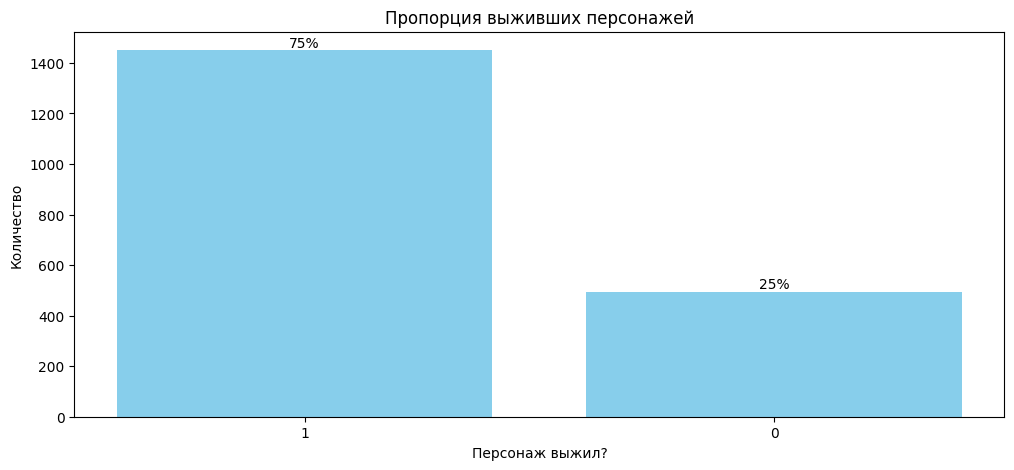

In [ ]:
plot_feature_distribution(got, 'is_alive')
plt.xlabel('Персонаж выжил?')
plt.ylabel('Количество')
plt.title('Пропорция выживших персонажей')
plt.show()

Соотношение между выжившими и погибшими составляет примерно 1:3: 75% людей выжили, а 25% погибли.

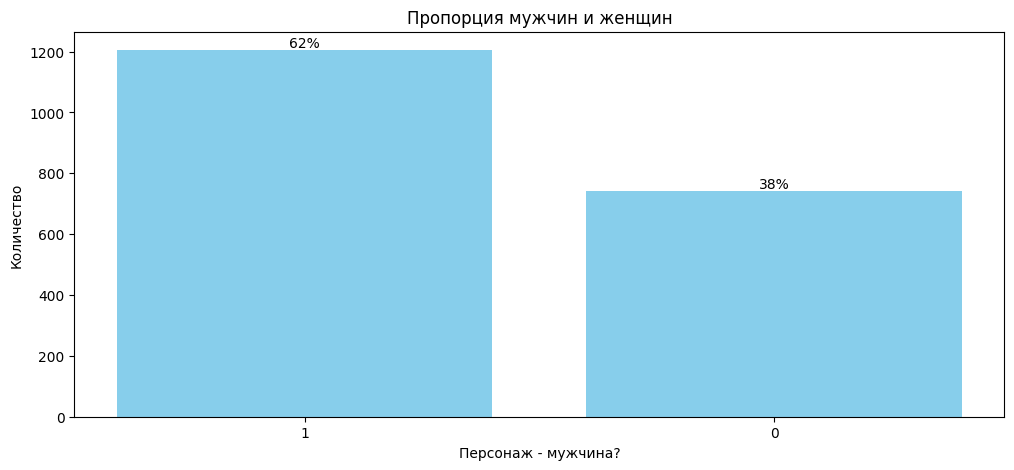

In [ ]:
plot_feature_distribution(got, 'male')
plt.xlabel('Персонаж - мужчина?')
plt.ylabel('Количество')
plt.title('Пропорция мужчин и женщин')
plt.show()

В выборке соотношение мужчин и женщин составляет примерно 3 к 2: 62% и 38% соответственно.

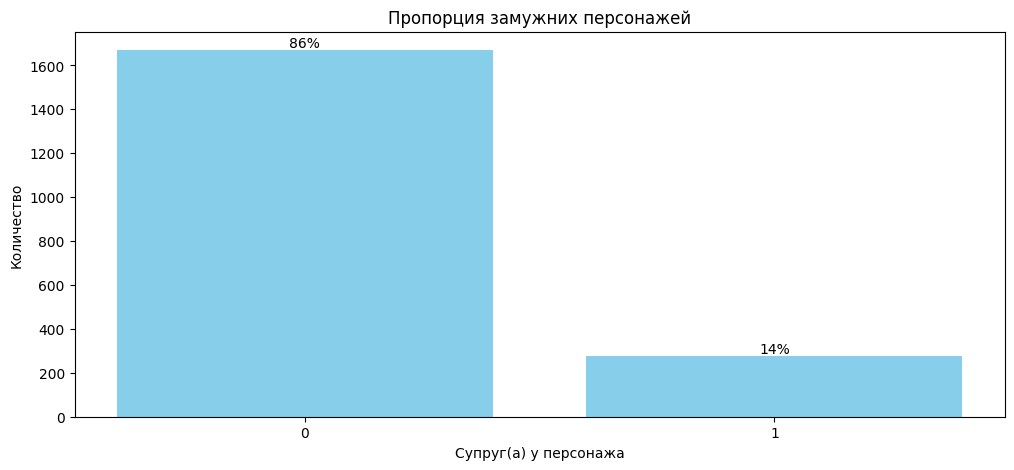

In [ ]:
plot_feature_distribution(got, 'is_married')
plt.xlabel('Супруг(а) у персонажа')
plt.ylabel('Количество')
plt.title('Пропорция замужних персонажей')
plt.show()

Персонажи, состоящие в браке (14%), появляются в серии реже, чем одиночки (86%). Хотя это не всегда точный способ предсказать шансы, его можно попробовать применить.

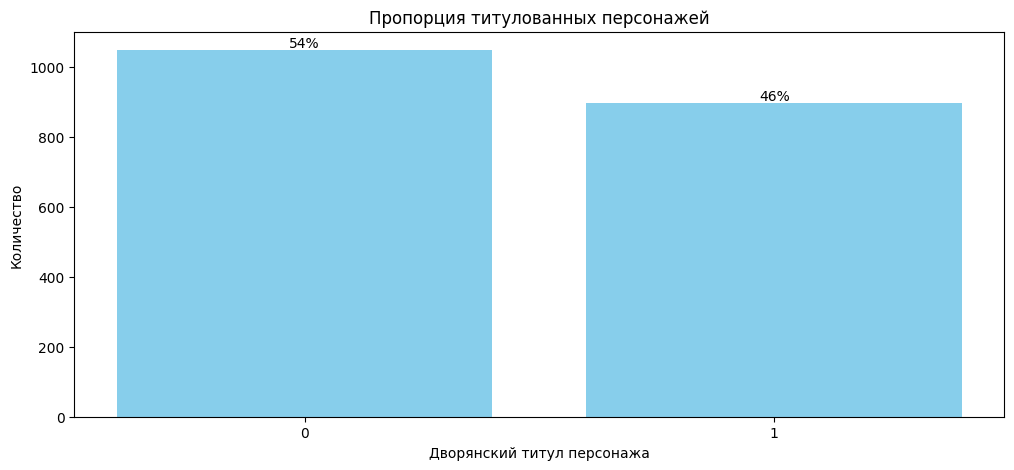

In [ ]:
plot_feature_distribution(got, 'is_noble')
plt.xlabel('Дворянский титул персонажа')
plt.ylabel('Количество')
plt.title('Пропорция титулованных персонажей')
plt.show()

Число титулованных персонажей составляет 46%, а нетитулованных – 54%, что свидетельствует о примерно равном распределении.

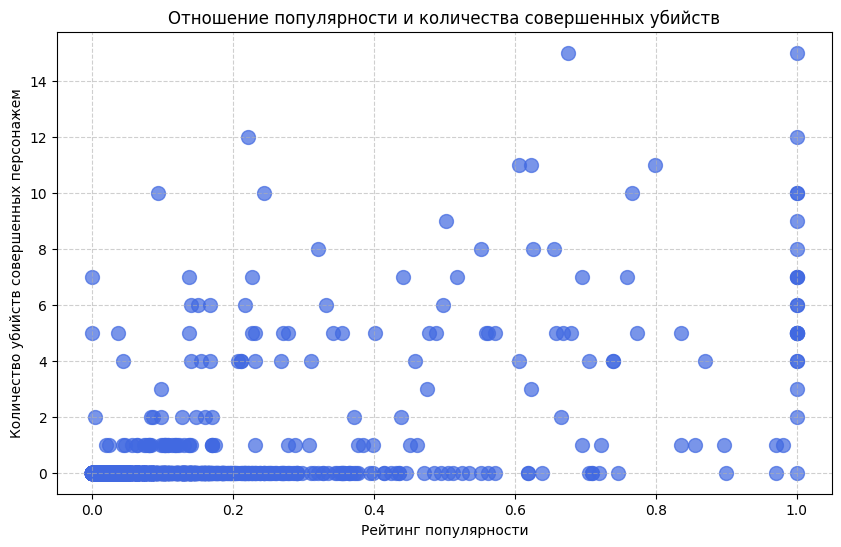

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(got['popularity'], got['num_dead_relations'], color='royalblue', alpha=0.7, s=100)
plt.title('Отношение популярности и количества совершенных убийств')
plt.xlabel('Рейтинг популярности')
plt.ylabel('Количество убийств совершенных персонажем')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

График демонстрирует, что распределение популярности и числа совершённых убийств носит почти случайный характер. Сложно установить линейную зависимость между этими двумя показателями. Для более детального анализа можно провести корреляционный тест.

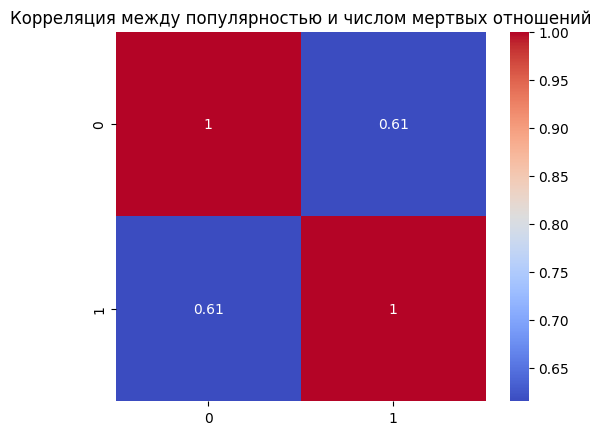

In [ ]:
corr = np.corrcoef(got['popularity'], got['num_dead_relations'])

# Создание тепловой карты
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title('Корреляция между популярностью и числом мертвых отношений')
plt.show()

Результаты теста показали среднюю корреляцию в 0,61. Это может быть связано с тем, что персонаж получает много экранного времени, а его популярность и количество совершенных убийств напрямую зависят от этого. Однако эта связь не является очевидной.

## Построение логистической регрессии

Планируется построить модели логистической регрессии для каждого из предикторов, доступных в наборе данных. Имеется пять предикторов, что предполагает создание пяти отдельных моделей. Начнётся с модели, содержащей только один предиктор, и последовательно будут добавляться оставшиеся.

Для оценки качества каждой модели будет использоваться показатель правдоподобия (Log-Likelihood). Этот критерий позволит определить, какая из моделей наиболее эффективно объясняет данные и лучше всего соответствует наблюдаемым результатам.

In [ ]:
# Создание и подгонка модели логистической регрессии с использованием обобщенной линейной модели (GLM)
model_1 = sm.GLM(
    # В качестве зависимой переменной используется 'is_alive', а в качестве предиктора - 'male'.
    got["is_alive"],
    got["male"],
    # Модель предполагает биномиальное распределение, что подходит для бинарной зависимой переменной.
    family=families.Binomial(),
).fit()
print(model_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               is_alive   No. Observations:                 1946
Model:                            GLM   Df Residuals:                     1945
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1254.3
Date:                Wed, 20 Nov 2024   Deviance:                       2508.6
Time:                        09:23:11   Pearson chi2:                 1.95e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            -0.1676
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
male           0.8257      0.063     13.190      0.0

In [ ]:
model_2 = sm.GLM(
    got["is_alive"],
    got[["male", "is_married"]],
    family=families.Binomial(),
).fit()
print(model_2.summary())

model_3 = sm.GLM(
    got["is_alive"],
    got[["male", "is_married", "num_dead_relations"]],
    family=families.Binomial(),
).fit()
print(model_3.summary())

model_4 = sm.GLM(
    got["is_alive"],
    got[["male", "is_married", "num_dead_relations", "is_noble"]],
    family=families.Binomial(),
).fit()
print(model_4.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               is_alive   No. Observations:                 1946
Model:                            GLM   Df Residuals:                     1944
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1249.0
Date:                Wed, 20 Nov 2024   Deviance:                       2498.0
Time:                        09:23:12   Pearson chi2:                 1.96e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            -0.1613
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
male           0.7780      0.064     12.126      0.0

Чтобы выжить лучше быть в браке, дворянином и менее агрессивным.

In [ ]:
model_5 = sm.GLM(
    got["is_alive"],
    got[["male", "is_married", "num_dead_relations", "is_noble", "popularity"]],
    family=families.Binomial(),
).fit()
print(model_5.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               is_alive   No. Observations:                 1946
Model:                            GLM   Df Residuals:                     1941
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1205.3
Date:                Wed, 20 Nov 2024   Deviance:                       2410.6
Time:                        09:23:12   Pearson chi2:                 1.99e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            -0.1103
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
male                   0.5746      0

Показатель правдоподобия и коэффициенты изменились незначительно. Более того, последняя переменная не проходит порог значимости в p-value < 0.05, так как оно равно 0.768. Это указывает на то, что результат незначим. Таким образом, можно исключить эту переменную и использовать в качестве финального результата предпоследнюю модель (model_4).

У модели с четырьмя предикторами наблюдается наилучший показатель правдоподобия.

Следует рассмотреть отношения шансов без логарифма, чтобы понять, насколько именно изменяются шансы в зависимости от изменений значений предикторов.

In [ ]:
model_odds = pd.DataFrame(np.exp(model_5.params), columns= ['Odds Ratio'])
print(model_odds)

                    Odds Ratio
male                  1.776362
is_married            1.511153
num_dead_relations    0.781058
is_noble              1.892507
popularity            0.886407


* Если персонаж — мужчина, его шансы на выживание увеличиваются на 77,6%.

* С каждым убийством других персонажей вероятность гибели героя снижается примерно на 12%.

* Если персонаж имеет дворянское происхождение, его шансы на спасение вырастают на 89%.

## Диагностика и надежность предсказания модели

In [ ]:
X = got[['male', 'is_married', 'num_dead_relations', 'is_noble', 'popularity']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

              feature       VIF
0                male  1.732705
1          is_married  1.270200
2  num_dead_relations  1.689705
3            is_noble  1.743861
4          popularity  2.244383


Мультиколлинеарность отсутствует, так как ни для одной переменной значение не оказывается больше консенсусного значения (четырех).

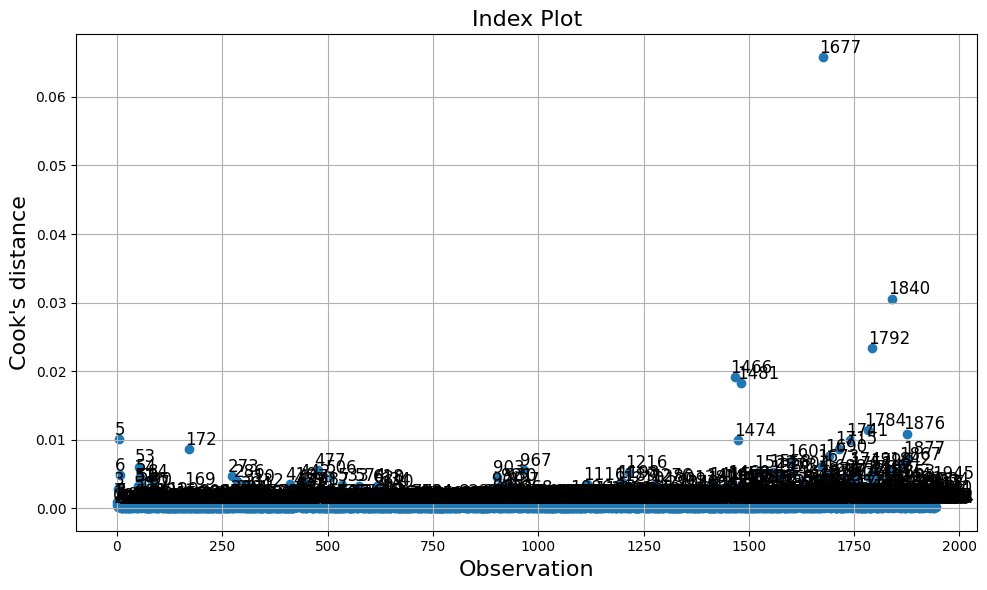

In [ ]:
# Дистанция Кука
fig, ax = plt.subplots(figsize=(10, 6))
infl = model_5.get_influence()
infl.plot_index(y_var="cooks", ax = ax)
ax.grid(True)
fig.tight_layout()

Влияетельные значения отсутствуют

## Результаты

- Если персонаж — мужчина, его шансы на выживание увеличиваются на 77,6%.
- С каждым убийством других персонажей вероятность гибели героя снижается примерно на 12%.
- Если персонаж имеет дворянское происхождение, его шансы на спасение вырастают на 89%.

Остальные гипотезы не подтвердились.